# BLE Proximity Experiment - SVR
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Initialize Dataset
Initialization of the data from the file

In [3]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
#distance_proximity_experiments were made with purple beacon
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
456,0.0,4.0,-83,-84.250000,3-4 meters,4.0
457,0.0,4.0,-86,-84.600000,3-4 meters,4.0
458,0.0,4.0,-87,-85.000000,3-4 meters,4.0
459,0.0,4.0,-86,-85.142857,3-4 meters,4.0


(461, 6)

### File Overall Description
Usage of describe pandas function on the dataset

In [4]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,461.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
coordinate_Y,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0
rssi_Value,461.0,-78.206074,9.461756,-94.0,-85.0,-81.00,-75.0,-50.0
rolling_mean_rssi,461.0,-78.065939,9.240107,-91.0,-84.0,-81.25,-76.0,-50.0
distance,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0


### Scanned Distances
Graphical display of the distances beacon/smartphone scanned in the experiment

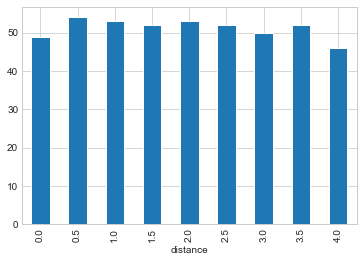

In [5]:
distances = dataset['distance']
reference_points = dataset.groupby(['distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

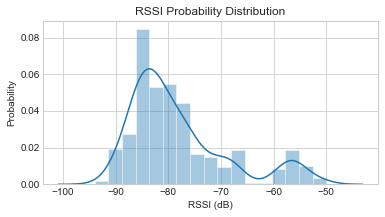

In [6]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

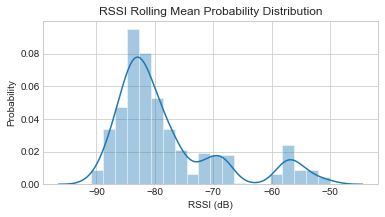

In [7]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

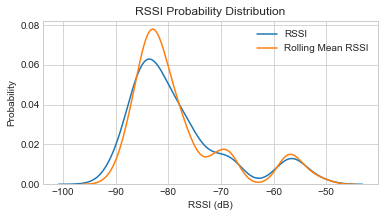

In [8]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [9]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
train_Y = pd.DataFrame(dataset['distance']).values.reshape(-1,1)
default_groups = dataset['distance'].map(str)
data_plot_means = dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

# FREE PARAMETERS
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
C_parameter_list = [0.25,0.5,1.0,10.0,100.0,1000.0] 
kernel_list = ("linear","poly","rbf","sigmoid")
gamma_list = [10,100,"scale","auto"]
epsilon_list = [0.1,0.2,0.3]

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-56.142857,-55.970408
0.5,-69.648148,-69.613316
1.0,-80.830189,-81.069969
1.5,-78.211538,-78.589148
2.0,-81.660377,-81.347469
2.5,-82.692308,-82.339034
3.0,-85.580000,-85.826857
3.5,-82.903846,-82.107601
4.0,-86.347826,-85.856548


### Plot Training Data
Graphical Display of the observations in the dataset

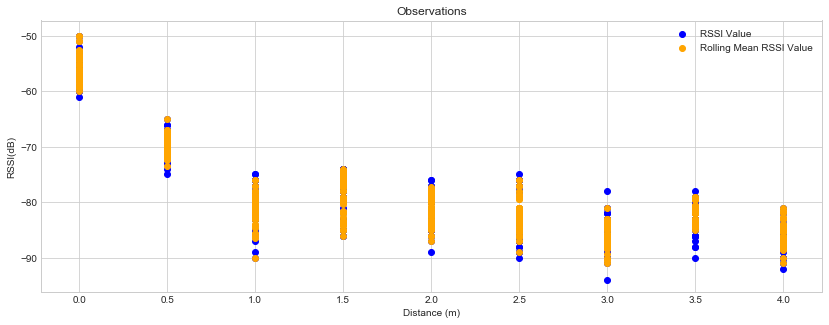

In [10]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Distance (m)')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [11]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

### SVR Experiments
Experiments with SVR algorithm

In [12]:
def compute_SVR(flag=0,colors=None,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                            cross_validation = None,C_parameter = 1.0, kernel_parameter='rbf', gamma_parameter="scale",
                epsilon_value =0.1):
    # Init the Linear Regressor Estimator
    svr_estimator = SVR(C=C_parameter,kernel=kernel_parameter,gamma=gamma_parameter,epsilon=epsilon_value)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,svr_estimator)
    else:
        main_estimator = svr_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        main_estimator.fit(testX_data,testY_data)
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    statistical_array = list()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        display(error_dataframe)
        df1 = error_dataframe.head(25)
        df1.plot(kind='bar',figsize=(12,6))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        X_grid = np.arange(min(testX_data), max(testX_data), 0.01) #this step required because data is feature scaled.
        X_grid = X_grid.reshape((len(X_grid), 1))
        plt.scatter(testX_data, testY_data, color = 'red')
        plt.plot(X_grid, main_estimator.predict(X_grid), color = 'blue')
        plt.title('Truth or Bluff (SVR)')
        plt.xlabel('RSSI')
        plt.ylabel('Distance')
        plt.show()
        plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
        plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
        plt.xlim(testY_data.min()-1, testY_data.max()+1)
        plt.ylim(testX_data.min()-1, testX_data.max()+1)
        plt.xticks(np.arange(testY_data.min(), testY_data.max()+1, 1.0))
        plt.yticks(np.arange(testX_data.min(), testX_data.max()+1, 2.0))
        if colors is not None:
            plt.plot(predict_test, testX_data, color=colors,label='SVR')
        else:
            plt.plot(predict_test, testX_data, color='red', label='SVR')
        # Show and place the legent
        plt.legend(loc='upper right')
        plt.show()
    observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
    error = pd.DataFrame(observed_errors, columns=["error"])
    result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
    return structure_data(result,coefficient_determination)


#### 1st Experiment - Check Overfitting scenario (Without Testing Data) Using RSSI
Use SVR to check the results on the training data alone

,Actual,Predicted
0,0.0,0.099979
1,0.0,0.099979
2,0.0,-0.057409
3,0.0,0.038340
4,0.0,-0.057409
...,...,...
456,4.0,2.595707
457,4.0,2.978688
458,4.0,3.055054
459,4.0,2.978688


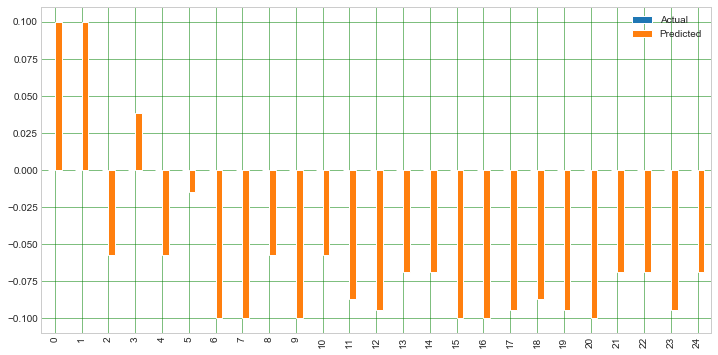

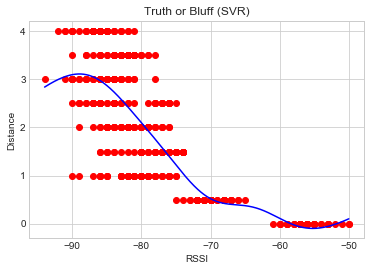

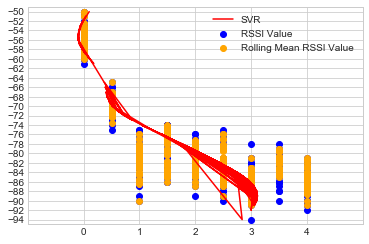

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.578767,0.581131,0.76232,0.762497,-0.521312,-0.068733,0.243641,1.373338,-1.744383,2.114112,0.641454


In [13]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_SVR(flag=1,trainX_data=train_X_rssi,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rssi,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 2nd Experiment - Check Overfitting scenario (Without Testing Data) Using Rolling Mean
Use SVR to check the results on the training data alone

,Actual,Predicted
0,0.0,0.100054
1,0.0,0.100054
2,0.0,0.029976
3,0.0,0.029976
4,0.0,-0.070670
...,...,...
456,4.0,2.812298
457,4.0,2.861147
458,4.0,2.913424
459,4.0,2.931067


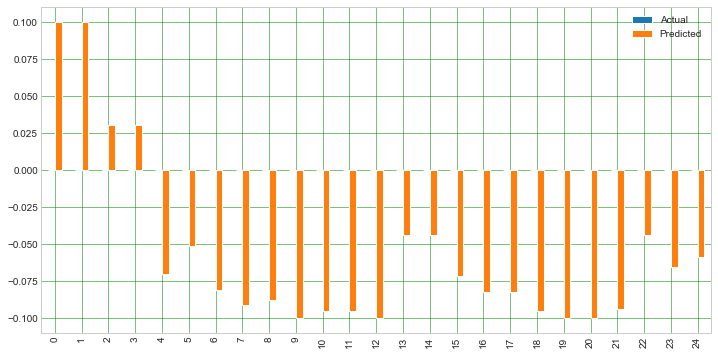

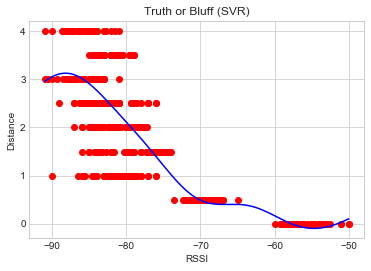

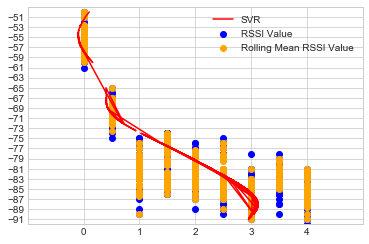

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.554628,0.566445,0.752625,0.753341,-0.379621,-0.044004,0.166146,1.413061,-1.714094,2.065774,0.650515


In [14]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_SVR(flag=1,trainX_data=train_X_rolling_mean,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 3rd Experiment - SVR with StratifiedKFold (RSSI pure)
Experiment using cross validation approach of StratifiedKFold

,Actual,Predicted
0,0.0,0.605928
1,0.0,0.605928
2,0.0,0.294496
3,0.0,0.496296
4,0.0,0.294496
...,...,...
456,4.0,2.783078
457,4.0,3.085365
458,4.0,3.156433
459,4.0,3.085365


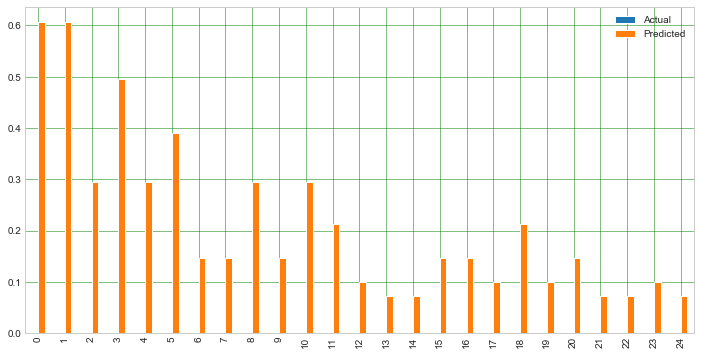

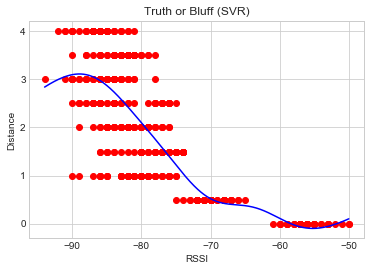

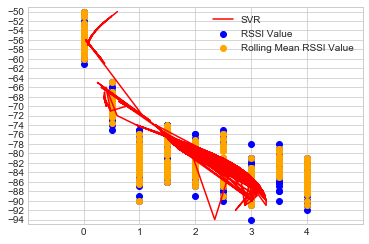

,Actual,Predicted
0,0.0,0.538320
1,0.0,0.538320
2,0.0,0.187935
3,0.0,0.413476
4,0.0,0.187935
...,...,...
456,4.0,2.779801
457,4.0,3.082617
458,4.0,3.147112
459,4.0,3.082617


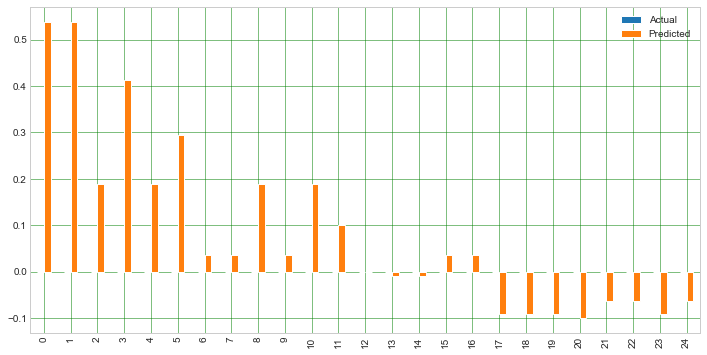

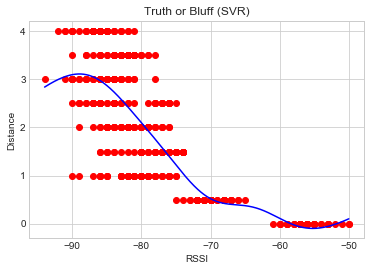

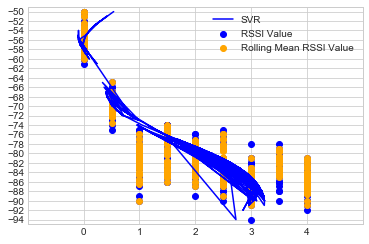

,Actual,Predicted
0,0.0,0.550362
1,0.0,0.550362
2,0.0,0.191556
3,0.0,0.423133
4,0.0,0.191556
...,...,...
456,4.0,2.707816
457,4.0,2.971222
458,4.0,3.026523
459,4.0,2.971222


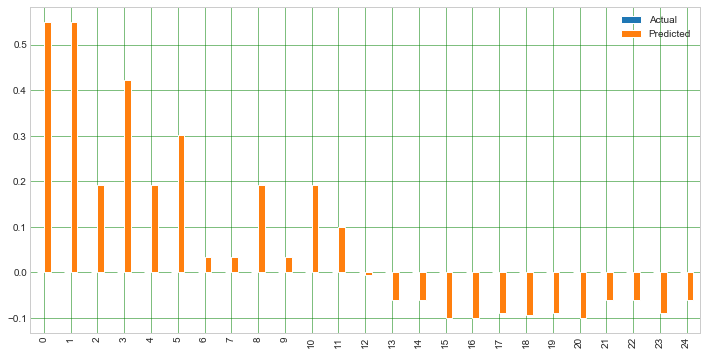

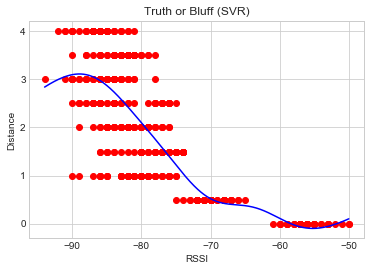

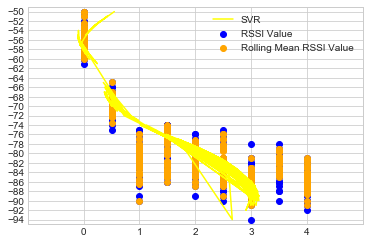

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
2,0.598497,0.603825,0.777062,0.777632,-0.522119,-0.028778,0.301317,1.440528,-1.768984,2.143457,0.627452,4
1,0.604539,0.615729,0.784684,0.785480,-0.548095,0.010765,0.297062,1.477505,-1.891313,2.226791,0.620107,3
0,0.626402,0.631555,0.794704,0.795307,-0.599694,0.099852,0.400191,1.487312,-1.899880,2.252634,0.610343,2


Number of Folds:  4


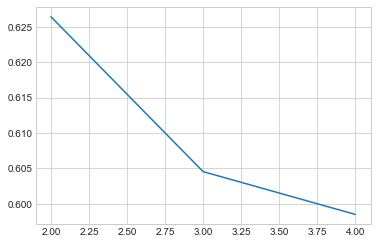

In [15]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,5)
colors = ['red','blue','yellow']
counter = 0
results = list()
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(train_X_rssi,default_groups,default_groups)
    result = compute_SVR(flag = 1,colors=colors[counter],testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 4th Experiment - SVR with StratifiedKFold (Rolling Mean)
Experiment using cross validation approach of StratifiedKFold

,Actual,Predicted
0,0.0,0.628441
1,0.0,0.628441
2,0.0,0.515836
3,0.0,0.515836
4,0.0,0.309161
...,...,...
456,4.0,2.811245
457,4.0,2.873108
458,4.0,2.946173
459,4.0,2.972831


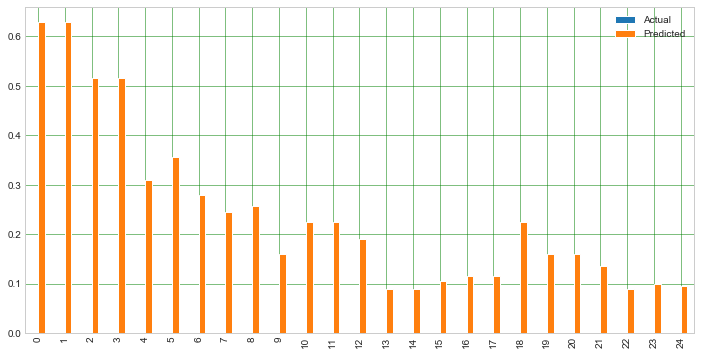

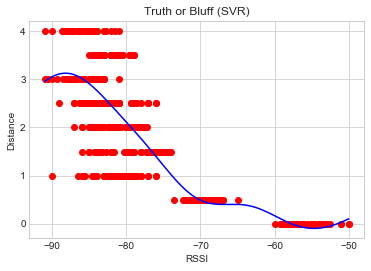

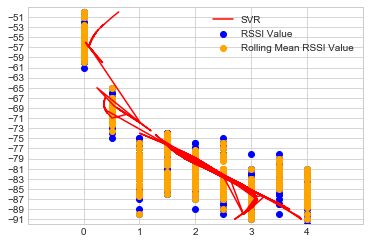

,Actual,Predicted
0,0.0,0.502794
1,0.0,0.502794
2,0.0,0.385264
3,0.0,0.385264
4,0.0,0.177657
...,...,...
456,4.0,2.885600
457,4.0,2.944842
458,4.0,3.013085
459,4.0,3.037535


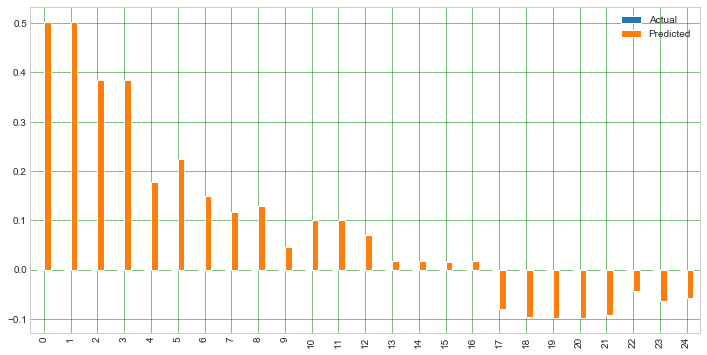

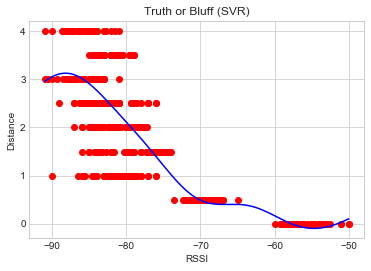

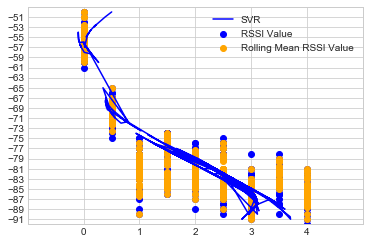

,Actual,Predicted
0,0.0,0.536422
1,0.0,0.536422
2,0.0,0.411854
3,0.0,0.411854
4,0.0,0.186649
...,...,...
456,4.0,2.837793
457,4.0,2.882612
458,4.0,2.932389
459,4.0,2.949745


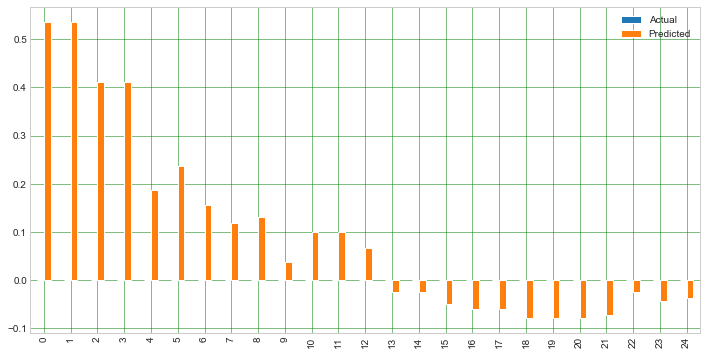

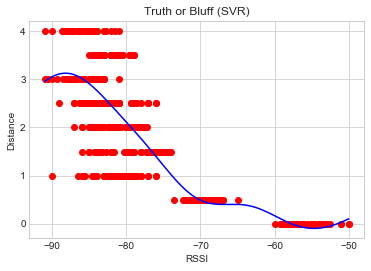

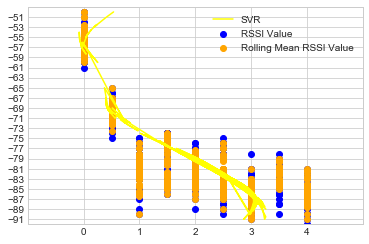

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
2,0.572633,0.586718,0.765975,0.766719,-0.389653,0.002685,0.248203,1.422007,-1.742496,2.085141,0.638006,4
1,0.589828,0.600255,0.774761,0.775569,-0.485117,-0.001600,0.306241,1.407777,-1.867446,2.098657,0.629655,3
0,0.605863,0.608629,0.780147,0.779843,-0.374377,0.083414,0.412026,1.364784,-1.683207,2.093494,0.624488,2


Number of Folds:  4


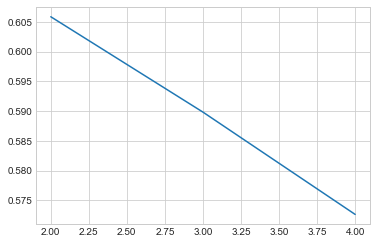

In [16]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,5)
results = list()
colors = ['red','blue','yellow']
counter = 0
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(train_X_rolling_mean,default_groups)
    result = compute_SVR(flag = 1,colors=colors[counter],testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 5th Experiment - SVR with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
0,0.515276,0.469257,0.685023,0.691137,-0.266569,0.025478,0.250877,1.025515,-1.424635,1.575365,0.714320,0.1
1,0.549258,0.511245,0.715014,0.718844,-0.370027,0.063665,0.291081,1.119365,-1.400437,1.887245,0.685966,0.2
2,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.898110,0.683997,0.3
3,0.554794,0.517470,0.719354,0.721014,-0.399969,-0.034644,0.330531,1.218600,-1.619349,1.807220,0.680916,0.4
4,0.566659,0.524444,0.724185,0.725060,-0.563929,-0.020567,0.362793,1.184542,-1.637207,1.775186,0.674442,0.5
5,0.587743,0.575173,0.758401,0.757544,-0.599663,0.016070,0.283002,1.158630,-1.707287,2.025723,0.645416,0.6
6,0.591664,0.588382,0.767060,0.766362,-0.609736,0.036385,0.295963,1.154365,-1.845635,2.174268,0.636515,0.7
7,0.596942,0.596512,0.772342,0.771228,-0.628128,0.029340,0.293577,1.242196,-1.835478,2.136776,0.631978,0.8
8,0.592822,0.595268,0.771536,0.768752,-0.653445,0.033463,0.314765,1.229705,-1.834452,2.097263,0.631281,0.9


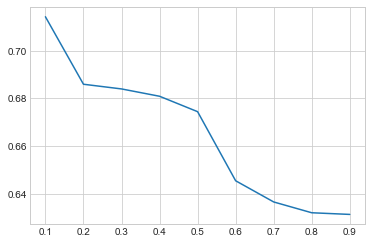

In [17]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rssi,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['r-squared'],ascending=False))
plt.plot(statistics['test_size'],statistics['r-squared'])

#### 6th Experiment - SVR with HoldOut (Rolling Mean)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
0,0.492445,0.428392,0.654517,0.661547,-0.123678,0.100267,0.234362,1.115218,-1.219932,1.211830,0.739199,0.1
1,0.521702,0.465147,0.682017,0.685690,-0.330244,0.009583,0.230600,1.144356,-1.248171,1.463967,0.714281,0.2
3,0.513737,0.485383,0.696695,0.697301,-0.373350,-0.029821,0.151327,1.162731,-1.639014,1.844744,0.700702,0.4
2,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.858020,0.693983,0.3
4,0.529060,0.500706,0.707606,0.708345,-0.391768,-0.026537,0.169683,1.164273,-1.633189,1.816944,0.689177,0.5
5,0.546089,0.541842,0.736099,0.736080,-0.432980,-0.015558,0.176986,1.222710,-1.661136,1.963467,0.665964,0.6
6,0.553949,0.559320,0.747877,0.747673,-0.450478,0.000374,0.177087,1.241742,-1.758258,2.070871,0.654469,0.7
7,0.560584,0.573939,0.757587,0.757329,-0.451041,-0.017608,0.174017,1.328571,-1.767336,2.071206,0.645905,0.8
8,0.575542,0.587646,0.766581,0.759329,-0.506369,-0.063565,0.138230,1.233235,-1.837861,1.902199,0.636002,0.9


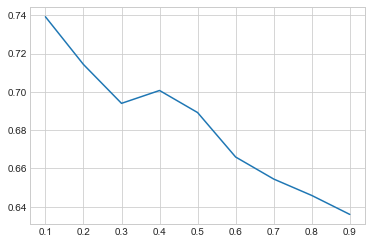

In [18]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rolling_mean,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['r-squared'],ascending=False))
plt.plot(statistics['test_size'],statistics['r-squared'])

#### 7th Experiment - SVR with LOGO (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [19]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
loo = compute_SVR(testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.979654,1.242327,1.114597,1.091708,-0.745431,0.417955,0.840946,1.79807,-1.873359,2.112472,0.233509


#### 8th Experiment - SVR with LOGO (Rolling Mean)
Experiment using cross validation approach of Leave One Group Out

In [20]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rolling_mean,train_Y,groups=default_groups)
loo = compute_SVR(testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.916256,1.140886,1.068123,1.03648,-0.498734,0.472499,0.807193,1.777041,-1.758561,2.085307,0.296096


#### 9th Experiment - Best cross-validation technique
Best parameters found using SVR

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method,type
4,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.858020,0.693983,HoldOut,Rolling Mean RSSI
1,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.898110,0.683997,HoldOut,RSSI Only
5,0.572633,0.586718,0.765975,0.766719,-0.389653,0.002685,0.248203,1.422007,-1.742496,2.085141,0.638006,Stratified K-Fold,Rolling Mean RSSI
2,0.598497,0.603825,0.777062,0.777632,-0.522119,-0.028778,0.301317,1.440528,-1.768984,2.143457,0.627452,Stratified K-Fold,RSSI Only
3,0.916256,1.140886,1.068123,1.036480,-0.498734,0.472499,0.807193,1.777041,-1.758561,2.085307,0.296096,LOO,Rolling Mean RSSI
0,0.979654,1.242327,1.114597,1.091708,-0.745431,0.417955,0.840946,1.798070,-1.873359,2.112472,0.233509,LOO,RSSI Only


Selected cross validation method:  HoldOut


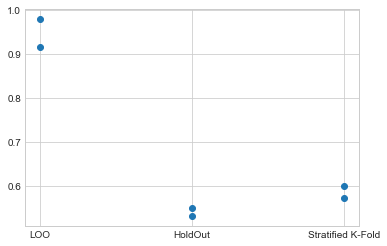

In [21]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
    holdout = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
    loo = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(trainX_data,default_groups,groups=default_groups)
    skfold = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### 10th Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing,preprocessingFunc,type
4,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.85802,0.693983,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
6,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.85802,0.693983,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI
5,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.85802,0.693983,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI
7,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.85802,0.693983,None,None,Rolling Mean RSSI
2,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.89811,0.683997,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only
1,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.89811,0.683997,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
0,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.89811,0.683997,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
3,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.89811,0.683997,None,None,RSSI Only


Selected Preprocessing:  StandardScaler


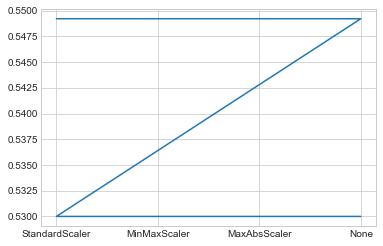

In [22]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### 11th Experiment - Running the SVR function with the different kernels

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,kernel,type
6,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.858020,0.693983,rbf,Rolling Mean RSSI
2,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.898110,0.683997,rbf,RSSI Only
0,0.632545,0.610751,0.781506,0.783328,-0.528572,0.019048,0.428571,1.119048,-1.623810,1.566666,0.625529,linear,RSSI Only
4,0.634353,0.613292,0.783129,0.782036,-0.583333,-0.100000,0.400000,1.135000,-1.600000,1.566666,0.623972,linear,Rolling Mean RSSI
1,0.890288,1.107563,1.052408,1.052347,-0.863248,0.093166,0.594783,1.490452,-2.416604,1.588984,0.320919,poly,RSSI Only
5,0.895489,1.120880,1.058716,1.057270,-0.870339,0.098549,0.598396,1.510661,-2.423860,1.578949,0.312753,poly,Rolling Mean RSSI
7,8.568255,168.155376,12.967474,13.009761,-7.585475,-0.238302,2.726568,31.023496,-21.823249,43.268667,-102.101359,sigmoid,Rolling Mean RSSI
3,10.513644,209.263258,14.465934,14.511386,-11.280509,-2.107061,3.646297,32.459982,-20.082027,46.285284,-127.305897,sigmoid,RSSI Only


Selected Kernel:  rbf


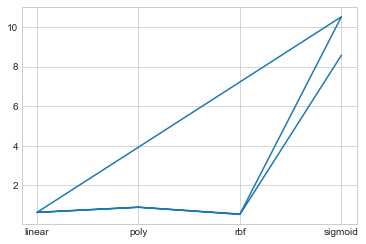

In [23]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','kernel','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for kernel in kernel_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                kernel_parameter=kernel)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                kernel_parameter=kernel)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),kernel_parameter=kernel)
        result.append(kernel)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['kernel'],statistics['mae'])
selected_kernel = statistics.sort_values(by=['mae'])['kernel'].head(1).values[0]
print("Selected Kernel: ",selected_kernel)

#### 12th Experiment - Running the SVR function with the different C parameters

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,C_parameter,type
11,0.521708,0.497871,0.705600,0.707884,-0.455676,0.016076,0.199857,1.125069,-1.387298,1.925456,0.694739,1000.00,Rolling Mean RSSI
10,0.526047,0.498903,0.706330,0.708717,-0.428595,-0.032061,0.182800,1.175705,-1.376712,1.910203,0.694107,100.00,Rolling Mean RSSI
7,0.527593,0.498863,0.706303,0.708739,-0.437159,-0.008105,0.219715,1.232995,-1.366157,1.861203,0.694131,0.50,Rolling Mean RSSI
9,0.529537,0.499983,0.707095,0.708770,-0.452404,-0.050861,0.203449,1.175315,-1.420283,1.851793,0.693445,10.00,Rolling Mean RSSI
8,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.858020,0.693983,1.00,Rolling Mean RSSI
6,0.531493,0.504393,0.710206,0.712592,-0.428485,0.023460,0.222296,1.233477,-1.367375,1.845030,0.690741,0.25,Rolling Mean RSSI
1,0.545167,0.514898,0.717564,0.720147,-0.403533,-0.015450,0.302649,1.384602,-1.400166,1.878571,0.684300,0.50,RSSI Only
3,0.545942,0.522764,0.723024,0.725639,-0.386287,0.003085,0.301419,1.353742,-1.453371,1.900540,0.679477,10.00,RSSI Only
0,0.547899,0.515259,0.717816,0.720372,-0.416425,0.047672,0.301713,1.381806,-1.399557,1.875268,0.684078,0.25,RSSI Only
4,0.548991,0.532419,0.729670,0.732239,-0.400164,0.010321,0.324517,1.350747,-1.400081,2.004175,0.673557,100.00,RSSI Only


Selected C Parameter:  1000.0


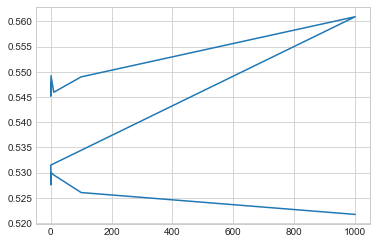

In [24]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','C_parameter','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for C_param in C_parameter_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                C_parameter=C_param)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                C_parameter=C_param)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),C_parameter=C_param)
        result.append(C_param)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['C_parameter'],statistics['mae'])
selected_c_parameter = statistics.sort_values(by=['mae'])['C_parameter'].head(1).values[0]
print("Selected C Parameter: ",selected_c_parameter)

#### 13th Experiment - Running the SVR function with the different gamma parameters

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,gamma,gammaStr,type
4,0.524142,0.497459,0.705307,0.707850,-0.461276,0.076893,0.146020,1.186249,-1.421687,1.926193,0.694992,10,10,Rolling Mean RSSI
7,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.858020,0.693983,auto,auto,Rolling Mean RSSI
6,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.858020,0.693983,scale,scale,Rolling Mean RSSI
5,0.542525,0.504858,0.710534,0.712918,-0.400061,0.098945,0.293432,1.275653,-1.424944,2.081349,0.690456,100,100,Rolling Mean RSSI
3,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.898110,0.683997,auto,auto,RSSI Only
2,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.898110,0.683997,scale,scale,RSSI Only
0,0.561591,0.549343,0.741177,0.743852,-0.399780,0.099873,0.394125,1.399556,-1.555389,1.899556,0.663180,10,10,RSSI Only
1,0.567710,0.561420,0.749279,0.751989,-0.400090,0.099953,0.302429,1.399917,-1.599955,1.899874,0.655776,100,100,RSSI Only


Selected Gamma Parameter:  10


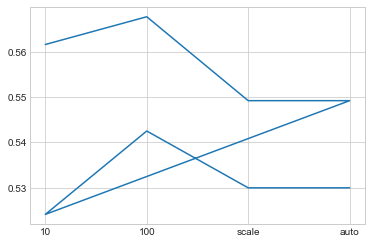

In [25]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','gamma','gammaStr','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for gamma_param in gamma_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                gamma_parameter=gamma_param)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                gamma_parameter=gamma_param)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),gamma_parameter=gamma_param)
        result.append(gamma_param)
        result.append(str(gamma_param))
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['gammaStr'],statistics['mae'])
selected_gamma = statistics.sort_values(by=['mae'])['gamma'].head(1).values[0]
print("Selected Gamma Parameter: ",selected_gamma)

#### 14th Experiment - Running the SVR function with the different epsilon parameters

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,epsilon,type
3,0.530003,0.499105,0.706474,0.708835,-0.423107,-0.032665,0.215802,1.224536,-1.380665,1.858020,0.693983,0.1,Rolling Mean RSSI
4,0.541769,0.497132,0.705076,0.707623,-0.431092,0.087234,0.220956,1.207652,-1.391012,1.864881,0.695192,0.2,Rolling Mean RSSI
0,0.549213,0.515393,0.717908,0.720421,-0.392402,0.013897,0.294889,1.401606,-1.399483,1.898110,0.683997,0.1,RSSI Only
1,0.557121,0.519494,0.720759,0.723336,-0.378892,0.080836,0.300971,1.354381,-1.465392,1.853073,0.681482,0.2,RSSI Only
5,0.559242,0.501133,0.707908,0.710433,-0.501994,0.085958,0.288511,1.119189,-1.447252,1.851658,0.692739,0.3,Rolling Mean RSSI
2,0.578363,0.529470,0.727647,0.728758,-0.319133,0.190608,0.333878,1.358481,-1.462319,1.856417,0.675365,0.3,RSSI Only


Selected Epsilon:  0.1


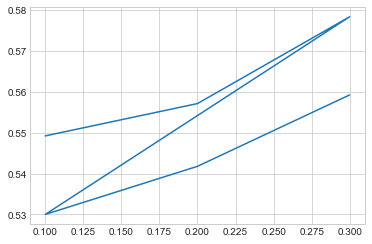

In [26]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','epsilon','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for epsilon in epsilon_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                epsilon_value=epsilon)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                epsilon_value=epsilon)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),epsilon_value=epsilon)
        result.append(epsilon)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['epsilon'],statistics['mae'])
selected_epsilon = statistics.sort_values(by=['mae'])['epsilon'].head(1).values[0]
print("Selected Epsilon: ",selected_epsilon)

### Run GridSearch for parameter tunning

In [27]:
results = []
tuned_parameters = {
    'svr__kernel':['rbf'],
    'svr__C':C_parameter_list,
    'svr__gamma':gamma_list,
    'svr__epsilon':epsilon_list
}
scores = ['r2']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    pipe = Pipeline([('standardizer', StandardScaler()), ('svr', SVR())])
    clf = GridSearchCV(
       pipe, tuned_parameters, cv=StratifiedKFold(n_splits=selected_fold, shuffle=True, random_state=6).split(train_X_rolling_mean, default_groups),scoring=score,n_jobs=-1,verbose=1
    )
    clf.fit(train_X_rolling_mean,train_Y.ravel())
    clf.best_params_['score'] = score
    results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

# Tuning hyper-parameters for r2

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    5.1s finished


,svr__C,svr__epsilon,svr__gamma,svr__kernel,score
0,100.0,0.1,10,rbf,r2


### Best Parameters
Display the best parameters tunned throughout the experiments

In [28]:
conclusion_cols=['C Parameter','Cross Validation','Kernel','Preprocessing','Gamma','Epsilon']
conclusion_list = [selected_c_parameter,selected_method,selected_kernel,selected_preprocessing,selected_gamma,selected_epsilon]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,C Parameter,Cross Validation,Kernel,Preprocessing,Gamma,Epsilon
0,1000.0,HoldOut,rbf,StandardScaler,10,0.1


### Best Results
Compute SVR with the best parameters in both RSSI and Rolling Mean

In [29]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
        result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(trainX_data,default_groups,groups=default_groups)
        result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
        result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('SVM Regressor')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../proximity_results.csv',mode='a',index=False,header=False)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
1,0.515903,0.481441,0.693860,0.695034,-0.37403,0.020022,0.346235,1.128662,-1.579536,2.108393,0.704813,Rolling Mean RSSI
0,0.567022,0.568443,0.753952,0.756209,-0.39968,0.090105,0.399797,1.411159,-1.400458,2.085156,0.651470,RSSI Only


### Best Results - Testing data being 1000 plot points
Experiment with testing data of 1000 plot points

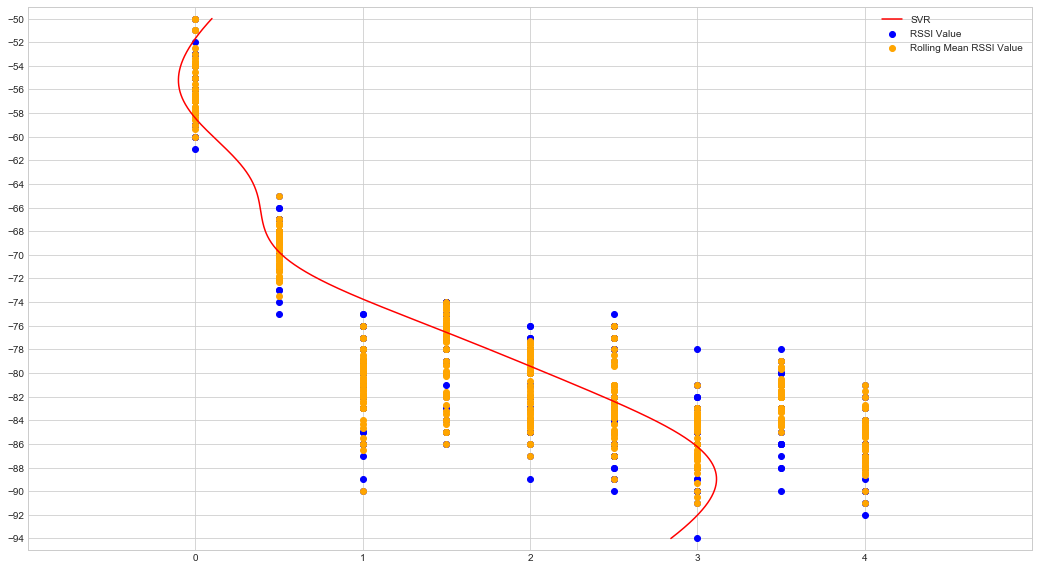

In [30]:
testX_data = np.linspace(dataset['rssi_Value'].min(), dataset['rssi_Value'].max(), 1000).reshape(-1,1)
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
svr_estimator = SVR()
main_estimator = make_pipeline(StandardScaler(),svr_estimator)
main_estimator.fit(train_X_rssi,train_Y.ravel())
predict_test = main_estimator.predict(testX_data)
plt.show()
plt.figure(figsize=(18,10))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.xlim(train_Y.min()-1, train_Y.max()+1)
plt.ylim(train_X_rssi.min()-1, train_X_rssi.max()+1)
plt.xticks(np.arange(train_Y.min(), train_Y.max()+1, 1.0))
plt.yticks(np.arange(train_X_rssi.min(), train_X_rssi.max()+1, 2.0))
plt.plot(predict_test, testX_data, color='red', label='SVR')
# Show and place the legent
plt.legend(loc='upper right')
plt.show()